## Project 2. Part 2 (Explore, Clean & Model)

In [1388]:
import re
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import diagnostic_plots.py as dp

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

ModuleNotFoundError: No module named 'diagnostic_plots.py'; 'diagnostic_plots' is not a package

### Define some useful functions

In [1364]:
#To clean the engine_size column (convert into floats)
def clean_engine(series):
    """Takes a series of strings and converts them into floats where possible.
    Returns a list of floats."""
    values = car_ad_dataset['Engine_Size']
    new_values = []
    for value in values:
        try:
            val = float(value)
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Clean up the price column
def clean_price(series):
    """Takes a series of strings, cleans them from text and converts them into floats where possible.
    Returns a list of floats."""
    values = series.str.split('€').str[0]
    new_values = []
    for value in values:
        try:
            val = float(re.sub(r'\s+', '', value))
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Clean up the mileage column
def clean_kms(series):
    """Takes a series of strings, cleans them from text and converts them into integers where possible.
    Returns a list of integers."""
    values = series.str.split('km').str[0]
    new_values = []
    for value in values:
        try:
            val = int(re.sub(r'\s+', '', value))
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Convert 'Fuel type' to numeric value (Petrol = 0, Diesel = 1) !If the car is electric, it assigns NaN
def fuel_bool(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for Petrol and 1 for Diesel.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'Petrol' or value == 'Petrol / LPG':
            val = int(0)
            new_values.append(val)
        elif value == 'Diesel' or value == 'Diesel / gas':
            val = int(1)
            new_values.append(val)
        else:
            val = np.NaN
            new_values.append(val)
    return new_values
        

### Unpickle the file

In [1365]:
with open('car_ad_dataset.pkl', 'rb') as picklefile:
    car_ad_dataset = pickle.load(picklefile)
    
#Verify that the result is as desired
car_ad_dataset.head()

,Audio/video equipment,Body type,Climate control,Color,Combined,Damage,Date of manufacture,Driven wheels,Electronics,Engine,...,Other features,Price in Lithuania,Safety,Security,Steering wheel,Tuning (improvements),Urban,VIN check,VIN number,Wheel size
0,"CD player,AUX input,Navigation/GPS,Handsfree kit",Wagon,Climate control,Black,NaN,No damages,2018-02,All wheel (4х4),"Electric mirrors,Electric boot lid,Galinio vai...","1995 cm³, 190 HP (139kW)",...,"Not exploited in Lithuania,Available for leasi...",44 900 €,"ABS,Traction control system,ESP iElectronic st...","Central locking,Immobilizer,Alarm",Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,NaN
1,NaN,Coupe,None,Blue,NaN,No damages,1992,Rear wheel drive (RWD),Electric windows,"1998 cm³, 156 HP (115kW)",...,NaN,4 400 €\n \n Sužinokite įmoką\n ...,NaN,NaN,Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,R17
2,"CD player,CD changer,Original audio system",Saloon / sedan,NaN,Gray / silver,6.80,Crashed,2005-04,Front wheel drive (FWD),"Electric mirrors,Electric windows,Outside temp...","2496 cm³, 163 HP (120kW)",...,"Not exploited in Lithuania,Service book",3 300 €\n \n Sužinokite įmoką\n ...,"ABS,ESP iElectronic stability program$(""#rel_E...",Central locking,Left hand drive (LHD),NaN,9.60,\n \n Check vehicle history\...,NaN,NaN
3,"CD player,Original audio system,Handsfree kit",Saloon / sedan,Climate control,Gray / silver,4.90,No damages,2006,Front wheel drive (FWD),"Electric mirrors,Electric windows,Automatic he...","1560 cm³, 110 HP (81kW)",...,Service book,3 900 €\n \n Sužinokite įmoką\n ...,"ABS,Traction control system,ESP iElectronic st...",Central locking,Left hand drive (LHD),NaN,6.20,\n \n Check vehicle history\...,NaN,NaN
4,"CD player,AUX input,USB input",Hatchback,Climate control,NaN,NaN,No damages,2011-04,Rear wheel drive (RWD),"Electric mirrors,Electric windows,Outside temp...","2000 cm³, 142 HP (105kW)",...,"Not exploited in Lithuania,Available for leasi...",6 000 €\n \n Sužinokite įmoką\n ...,"ABS,EBD iElectronic brakeforce distribution$(""...",NaN,Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,NaN


In [1366]:
#Check out the shape and get info
print('The shape is:', str(car_ad_dataset.shape), '\n');
car_ad_dataset.info()

The shape is: (1020, 35) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 35 columns):
Audio/video equipment         636 non-null object
Body type                     886 non-null object
Climate control               577 non-null object
Color                         724 non-null object
Combined                      389 non-null object
Damage                        886 non-null object
Date of manufacture           886 non-null object
Driven wheels                 682 non-null object
Electronics                   780 non-null object
Engine                        875 non-null object
Engine_Size                   886 non-null object
Euro standard                 306 non-null object
Export price                  225 non-null object
Exterior                      763 non-null object
Extra-urban                   397 non-null object
First registration country    451 non-null object
Fuel type                     886 non-null object
Gearbox         

In [1367]:
car_ad_dataset.describe()

,Audio/video equipment,Body type,Climate control,Color,Combined,Damage,Date of manufacture,Driven wheels,Electronics,Engine,...,Other features,Price in Lithuania,Safety,Security,Steering wheel,Tuning (improvements),Urban,VIN check,VIN number,Wheel size
count,636,886,577,724,389,886,886,682,780,875,...,534,886,722,560,886,53,392,883,127,541
unique,265,10,3,11,78,5,264,3,337,481,...,46,320,58,11,2,12,104,2,127,9
top,"CD player,Original audio system",Saloon / sedan,Climate control,Gray / silver,6.00,No damages,2005,Front wheel drive (FWD),Electric windows,"1968 cm³, 140 HP (103kW)",...,"Not exploited in Lithuania,Service book,Cataly...",2 500 €\n \n Sužinokite įmoką\n ...,Airbags,"Central locking,Immobilizer,Alarm",Left hand drive (LHD),Spoilers,8.00,\n \n Check vehicle history\...,WVWZZZ1JZ1W114426,R16
freq,73,231,408,262,26,841,18,439,98,19,...,88,17,189,178,876,19,24,756,1,170


In [1368]:
#Explore the dataset
car_ad_dataset.count().sort_values(ascending = False)

Gearbox                       886
Price in Lithuania            886
Fuel type                     886
Make_Model                    886
Number of doors               886
Date of manufacture           886
Engine_Size                   886
Damage                        886
Steering wheel                886
Body type                     886
VIN check                     883
Engine                        875
Interior                      787
Electronics                   780
Exterior                      763
Color                         724
Safety                        722
Mileage                       715
Driven wheels                 682
Number of seats               654
Audio/video equipment         636
Climate control               577
Security                      560
Wheel size                    541
Other features                534
MOT test expiry               515
First registration country    451
Extra-urban                   397
Urban                         392
Combined      

### Clean the dataset

**Initial cleaning and formatting**

In [1369]:
#Split the Make_Model column
car_ad_dataset['Make'], car_ad_dataset['Model'] = car_ad_dataset['Make_Model'].str.split(' ', 1).str

In [1370]:
#Clean up the Engine_Size column from l.
car_ad_dataset['Engine_Size'] = car_ad_dataset['Engine_Size'].str.split(' ', 2).str[1]
car_ad_dataset['Engine_Size_l'] = clean_engine(car_ad_dataset['Engine_Size'])

In [1371]:
#Clean the Engine column
#Some of the cars don't have the cm3, so instead this takes HP or kW, will have to drop those later on!!!
car_ad_dataset['Engine_cm3'] = pd.to_numeric(car_ad_dataset['Engine'].str.split(' ').str[0])

In [1372]:
#Only keep the Year of manufacture
car_ad_dataset['Year_of_manufacture'] = pd.to_numeric(car_ad_dataset['Date of manufacture'].str[:4])

In [1373]:
#Clean up the price column and convert to a float
car_ad_dataset['Price'] = clean_price(car_ad_dataset['Price in Lithuania'])

In [1374]:
#Clean up the milage column to remove 'km'
car_ad_dataset['Mileage_km'] = clean_kms(car_ad_dataset['Mileage'])

In [1375]:
#Sanity check (values in fuel type)
car_ad_dataset['Fuel type'].unique()

array(['Diesel', 'Petrol', 'Petrol / LPG', 'Diesel / gas', 'Other',
       'Petrol / electricity', 'Electricity', nan], dtype=object)

In [1376]:
#Convert Fuel type column to boolean (0,1)
car_ad_dataset['Fuel type'] = fuel_bool(car_ad_dataset['Fuel type'])

**Shorten the dataset & re-evaluate**

In [1377]:
#Shorten the dataset by picking the most logical features
short_car_ad_dataset = car_ad_dataset[['Make', 'Model', 'Body type', 'Year_of_manufacture', 'Damage', 'Engine_Size_l', 'Engine_cm3', 'Fuel type', 'Gearbox', 'Mileage_km','Number of doors', 'Color', 'Steering wheel', 'Price']]
short_car_ad_dataset.head()

,Make,Model,Body type,Year_of_manufacture,Damage,Engine_Size_l,Engine_cm3,Fuel type,Gearbox,Mileage_km,Number of doors,Color,Steering wheel,Price
0,BMW,520,Wagon,2018.0,No damages,2.0,1995.0,1.0,Automatic,8100.0,4/5,Black,Left hand drive (LHD),44900.0
1,Toyota,MR 2,Coupe,1992.0,No damages,2.0,1998.0,0.0,Manual,270000.0,2/3,Blue,Left hand drive (LHD),4400.0
2,Audi,A4,Saloon / sedan,2005.0,Crashed,2.5,2496.0,1.0,Manual,265000.0,4/5,Gray / silver,Left hand drive (LHD),3300.0
3,Volvo,S40,Saloon / sedan,2006.0,No damages,1.6,1560.0,1.0,Manual,241000.0,4/5,Gray / silver,Left hand drive (LHD),3900.0
4,BMW,120,Hatchback,2011.0,No damages,2.0,2000.0,1.0,Manual,193000.0,4/5,NaN,Left hand drive (LHD),6000.0


In [1378]:
#Get the info on the shorten dataset
short_car_ad_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 14 columns):
Make                   886 non-null object
Model                  886 non-null object
Body type              886 non-null object
Year_of_manufacture    886 non-null float64
Damage                 886 non-null object
Engine_Size_l          855 non-null float64
Engine_cm3             875 non-null float64
Fuel type              872 non-null float64
Gearbox                886 non-null object
Mileage_km             715 non-null float64
Number of doors        886 non-null object
Color                  724 non-null object
Steering wheel         886 non-null object
Price                  886 non-null float64
dtypes: float64(6), object(8)
memory usage: 111.6+ KB


**Clean the small dataset of NaN values**

In [1379]:
#Drop all the cars that are missing at least one of the values
clean_car_ad_dataset = short_car_ad_dataset.dropna(how = 'any')

#And review again
clean_car_ad_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576 entries, 0 to 902
Data columns (total 14 columns):
Make                   576 non-null object
Model                  576 non-null object
Body type              576 non-null object
Year_of_manufacture    576 non-null float64
Damage                 576 non-null object
Engine_Size_l          576 non-null float64
Engine_cm3             576 non-null float64
Fuel type              576 non-null float64
Gearbox                576 non-null object
Mileage_km             576 non-null float64
Number of doors        576 non-null object
Color                  576 non-null object
Steering wheel         576 non-null object
Price                  576 non-null float64
dtypes: float64(6), object(8)
memory usage: 67.5+ KB


In [1380]:
#Let's have a look again
clean_car_ad_dataset.head()

,Make,Model,Body type,Year_of_manufacture,Damage,Engine_Size_l,Engine_cm3,Fuel type,Gearbox,Mileage_km,Number of doors,Color,Steering wheel,Price
0,BMW,520,Wagon,2018.0,No damages,2.0,1995.0,1.0,Automatic,8100.0,4/5,Black,Left hand drive (LHD),44900.0
1,Toyota,MR 2,Coupe,1992.0,No damages,2.0,1998.0,0.0,Manual,270000.0,2/3,Blue,Left hand drive (LHD),4400.0
2,Audi,A4,Saloon / sedan,2005.0,Crashed,2.5,2496.0,1.0,Manual,265000.0,4/5,Gray / silver,Left hand drive (LHD),3300.0
3,Volvo,S40,Saloon / sedan,2006.0,No damages,1.6,1560.0,1.0,Manual,241000.0,4/5,Gray / silver,Left hand drive (LHD),3900.0
6,Mazda,3,Hatchback,2008.0,Crashed,1.6,1600.0,1.0,Manual,193533.0,4/5,Gray / silver,Left hand drive (LHD),1499.0


In [1381]:
#Remove cars that are damaged
clean_car_ad_dataset = clean_car_ad_dataset[clean_car_ad_dataset['Damage'] == 'No damages']
clean_car_ad_dataset.drop(columns = ['Damage'], inplace = True)

#Remove cars that are not Left hand drive
clean_car_ad_dataset = clean_car_ad_dataset[clean_car_ad_dataset['Steering wheel'] == 'Left hand drive (LHD)']
clean_car_ad_dataset.drop(columns = ['Steering wheel'], inplace = True)

#Clean up Engine_cm3 column from potential HP values --NOT WORKING!!!
#clean_car_ad_dataset['Engine_cm3'] = clean_car_ad_dataset[clean_car_ad_dataset['Engine_cm3'] > 600.0]
#clean_car_ad_dataset['Engine_cm3']

clean_car_ad_dataset.head()

,Make,Model,Body type,Year_of_manufacture,Engine_Size_l,Engine_cm3,Fuel type,Gearbox,Mileage_km,Number of doors,Color,Price
0,BMW,520,Wagon,2018.0,2.0,1995.0,1.0,Automatic,8100.0,4/5,Black,44900.0
1,Toyota,MR 2,Coupe,1992.0,2.0,1998.0,0.0,Manual,270000.0,2/3,Blue,4400.0
3,Volvo,S40,Saloon / sedan,2006.0,1.6,1560.0,1.0,Manual,241000.0,4/5,Gray / silver,3900.0
10,Renault,Espace,MPV / minivan,1998.0,2.0,2000.0,0.0,Manual,320000.0,4/5,Green / olive,450.0
12,BMW,320,Coupe,2001.0,2.2,2171.0,0.0,Manual,271000.0,2/3,Blue,2450.0


In [1382]:
clean_car_ad_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 543 entries, 0 to 879
Data columns (total 12 columns):
Make                   543 non-null object
Model                  543 non-null object
Body type              543 non-null object
Year_of_manufacture    543 non-null float64
Engine_Size_l          543 non-null float64
Engine_cm3             543 non-null float64
Fuel type              543 non-null float64
Gearbox                543 non-null object
Mileage_km             543 non-null float64
Number of doors        543 non-null object
Color                  543 non-null object
Price                  543 non-null float64
dtypes: float64(6), object(6)
memory usage: 55.1+ KB


### Let's try modelling

In [1383]:
#Check the correlation between different variables
clean_car_ad_dataset.corr()

,Year_of_manufacture,Engine_Size_l,Engine_cm3,Fuel type,Mileage_km,Price
Year_of_manufacture,1.000000,-0.117711,-0.120135,0.114675,-0.224408,0.611112
Engine_Size_l,-0.117711,1.000000,0.999721,-0.032575,0.044253,0.254978
Engine_cm3,-0.120135,0.999721,1.000000,-0.035037,0.044049,0.253057
Fuel type,0.114675,-0.032575,-0.035037,1.000000,0.189923,0.023590
Mileage_km,-0.224408,0.044253,0.044049,0.189923,1.000000,-0.196523
Price,0.611112,0.254978,0.253057,0.023590,-0.196523,1.000000


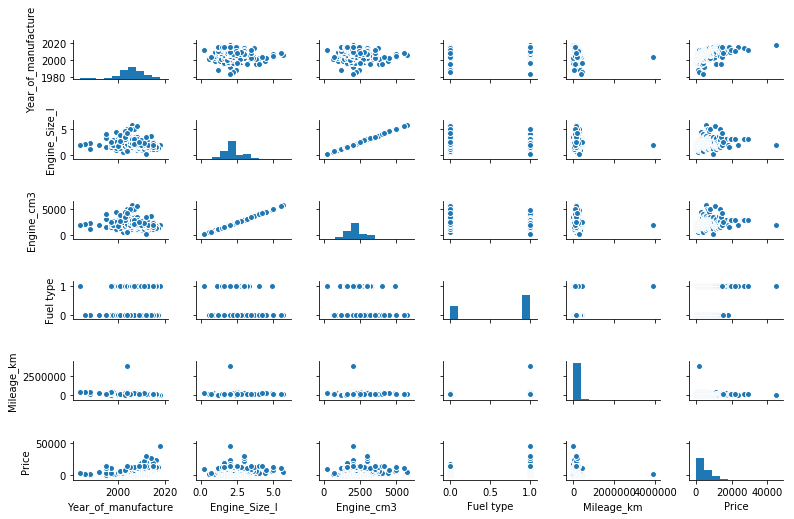

In [1384]:
#Visualize the correlations
sns.pairplot(clean_car_ad_dataset, size = 1.2, aspect=1.5);

In [1385]:
#Create the feature matrix and target vector
y, X = patsy.dmatrices('Price ~ Year_of_manufacture + Engine_Size_l + Engine_cm3 + Mileage_km', clean_car_ad_dataset)
car_ad_model = sm.OLS(y, X)
car_ad_model_fit = car_ad_model.fit()
car_ad_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     127.4
Date:                Thu, 12 Jul 2018   Prob (F-statistic):           1.81e-76
Time:                        20:52:14   Log-Likelihood:                -5136.8
No. Observations:                 543   AIC:                         1.028e+04
Df Residuals:                     538   BIC:                         1.031e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.163e+06    5.9e+04    -19.698      0.000   -1.28e+06   -1.05e+06
Year_of_manufacture   579.9706     29.385     19.737      0.000     522.247     637.694
Engine_Size_l        5742.9193   8562.155      0.671      0.503   -1.11e+04    2.26e+04
Engine_cm3             -3.5725      8.550     -0.418      0.676     -20.368      13.223
Mileage_km             -0.0017      0.001     -2.182      0.030      -0.003      -0.000
==============================================================================
Omnibus:                      482.209   Durbin-Watson:                   0.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17947.664
Skew:                           3.728   Prob(JB):                         0.00
Kurtosis:                      30.160   Cond. No.                     1.23e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1387]:
# Use statsmodels to plot the residuals
#car_ad_model_fit.resid.plot(style='o', figsize=(12,8));

car_ad_model_fit.resid

array([ 3.28222622e+04,  7.85398532e+03, -8.21030716e+01,  5.15646387e+02,
        1.55393992e+02, -2.74290675e+03,  8.74664714e+02, -3.20537254e+02,
       -6.19997452e+02,  5.41491025e+02,  8.83966981e+02, -1.01084470e+03,
       -2.00945679e+03, -1.21418795e+03, -2.28760817e+03,  1.93635258e+03,
        4.41825102e+03,  1.28654831e+04, -7.60387219e+02, -2.18833260e+03,
       -5.54086238e+02, -1.56696710e+03, -2.93955225e+03, -1.85722576e+03,
       -2.48829179e+03, -2.43439970e+03, -1.62398498e+03, -2.30410446e+03,
        3.04173334e+02, -1.49812857e+03, -6.09645499e+02, -1.76973083e+03,
       -1.81183888e+03,  5.37343238e+02, -6.31624145e+02, -1.77703617e+03,
       -1.13283138e+03,  1.49609791e+02,  3.88885310e+02,  4.17844548e+02,
        5.38355769e+03,  1.22349051e+03,  1.44101846e+03,  3.25575148e+03,
        4.46121932e+03,  4.80291836e+03,  3.03647205e+03,  2.76254720e+03,
        3.13479245e+03,  4.68687157e+03,  5.94105405e+03,  7.80131928e+03,
        6.37125090e+03,  